In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture #gmmclassification
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from afinn import Afinn
import pickle

In [2]:
#downloading the data
data = pd.read_csv('https://raw.githubusercontent.com/insaid2018/Term-3/master/Data/CaseStudy/Womens%20Clothing%20E-Commerce%20Reviews.csv',index_col = [0]) #removes unnamed:0
data.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


Supprimer les données manquantes

In [3]:
data.dropna(inplace = True) 
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19662 entries, 2 to 23485
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Clothing ID              19662 non-null  int64 
 1   Age                      19662 non-null  int64 
 2   Title                    19662 non-null  object
 3   Review Text              19662 non-null  object
 4   Rating                   19662 non-null  int64 
 5   Recommended IND          19662 non-null  int64 
 6   Positive Feedback Count  19662 non-null  int64 
 7   Division Name            19662 non-null  object
 8   Department Name          19662 non-null  object
 9   Class Name               19662 non-null  object
dtypes: int64(5), object(5)
memory usage: 1.7+ MB


Suppprimer les colonnes qui ne coniennent pas des informations pour le modèle

In [4]:
review_data = data.drop(['Clothing ID','Class Name','Department Name','Title','Division Name','Recommended IND'], axis = 1)
review_data.head()

,Age,Review Text,Rating,Positive Feedback Count
2,60,I had such high hopes for this dress and reall...,3,0
3,50,"I love, love, love this jumpsuit. it's fun, fl...",5,0
4,47,This shirt is very flattering to all due to th...,5,6
5,49,"I love tracy reese dresses, but this one is no...",2,4
6,39,I aded this in my basket at hte last mintue to...,5,1


In [6]:
af = Afinn()
# convertir en miscule 
review_data['Review Text'] = review_data['Review Text'].str.lower()
# donner score à chaque avis
review_data['sent_score'] = review_data.apply(lambda row: af.score(row['Review Text']), axis = 1)
review_data.to_csv('review_with_score.csv')
sent_score = review_data['sent_score'].values
with open('sent.txt','wb') as fp:
    pickle.dump(sent_score, fp)
    
with open('sent.txt', 'rb') as fp:
    b = pickle.load(fp)

print(b)

[ 5. 22.  6. ...  9. 14.  9.]


In [7]:
review_data.head()

,Age,Review Text,Rating,Positive Feedback Count,sent_score
2,60,i had such high hopes for this dress and reall...,3,0,5.0
3,50,"i love, love, love this jumpsuit. it's fun, fl...",5,0,22.0
4,47,this shirt is very flattering to all due to th...,5,6,6.0
5,49,"i love tracy reese dresses, but this one is no...",2,4,7.0
6,39,i aded this in my basket at hte last mintue to...,5,1,-3.0


Rendre tous les scores positifs pour Gérer les données dans le bon format pour les algorithmes

In [8]:
# supprimer colonne review(colonne du text)
scores_data = review_data.drop('Review Text', axis = 1)
# chercher la valeur négative la plus base.
min_scores = abs(np.min(scores_data['sent_score']))
# décaler les scores en ajouter la valeur absolue du score négatif
scores_data['sent_score'] = scores_data['sent_score']+ min_scores
scores_data.head()

,Age,Rating,Positive Feedback Count,sent_score
2,60,3,0,18.0
3,50,5,0,35.0
4,47,5,6,19.0
5,49,2,4,20.0
6,39,5,1,10.0


Visualisation du data(affiche de la répartition)

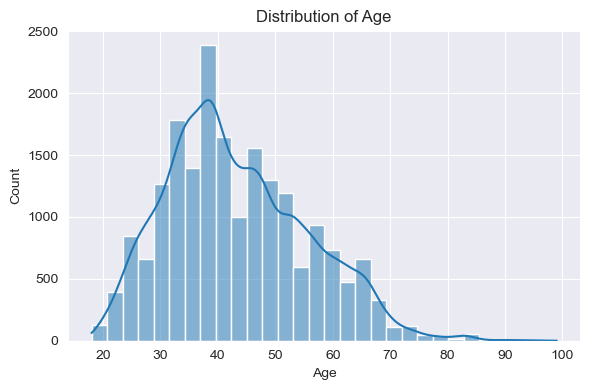

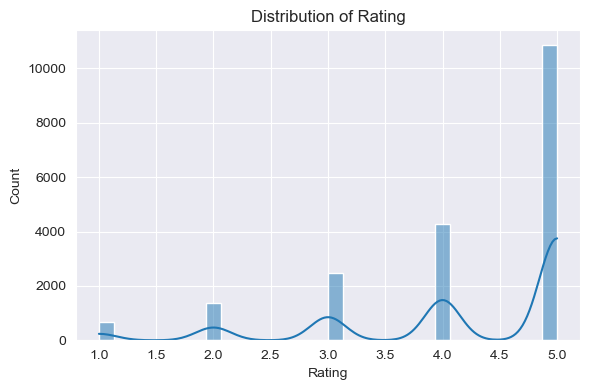

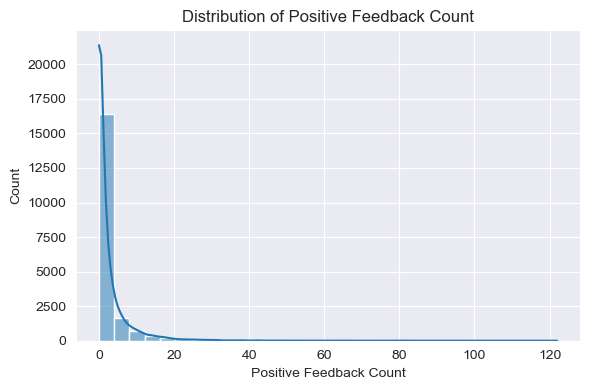

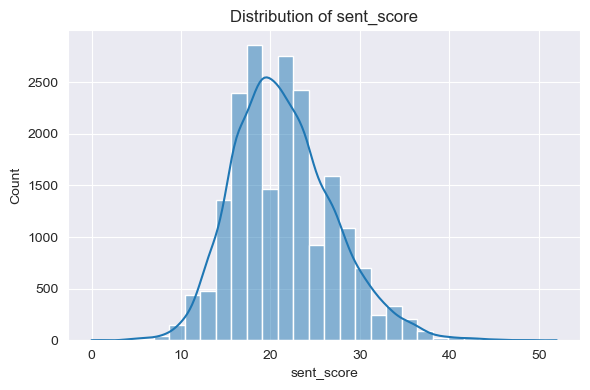

In [9]:

sns.set_style('darkgrid')

for i, col in enumerate(scores_data.columns):
    plt.figure(i, figsize=(6, 4))
    sns.histplot(scores_data[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.tight_layout() 

plt.show() 


## La majorité des données ne suivent pas une distribution normale.
## L'algorithme K-Means ne gère pas bien les données asymétriques.
## Transforme chaque variable pour qu’elle suive une distribution normale, en utilisant une transformation logarithmique.
## Pour s’assurer que toutes les valeurs sont positives, on ajoute 1 à chaque valeur.

In [26]:
# Partir de scores_data qui doit être défini avant (sans la colonne 'Review Text')
# Ajouter 1 à toutes les valeurs pour éviter log(0) ou log de valeurs négatives
tmp = scores_data + 1

# Appliquer la transformation logarithmique à toutes les colonnes
for col in tmp.columns:
    tmp[col] = np.log(tmp[col])

# Stocker dans scores_updated
scores_updated = tmp


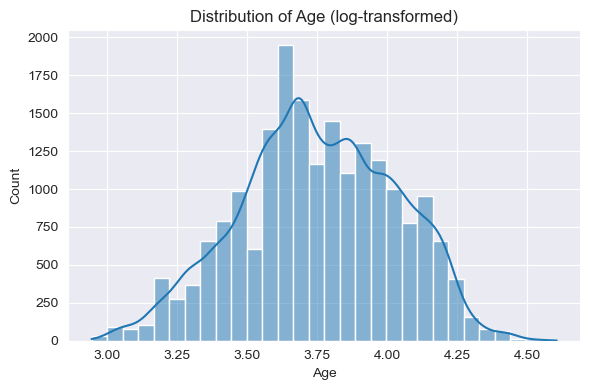

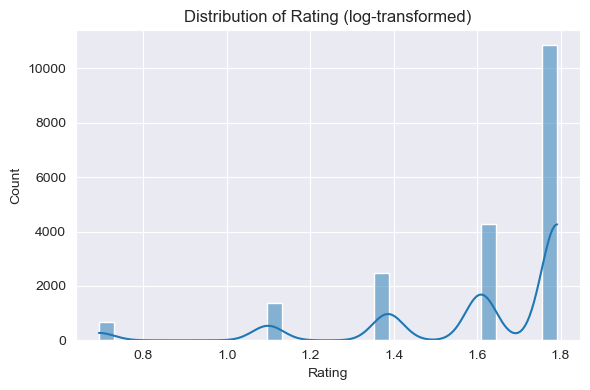

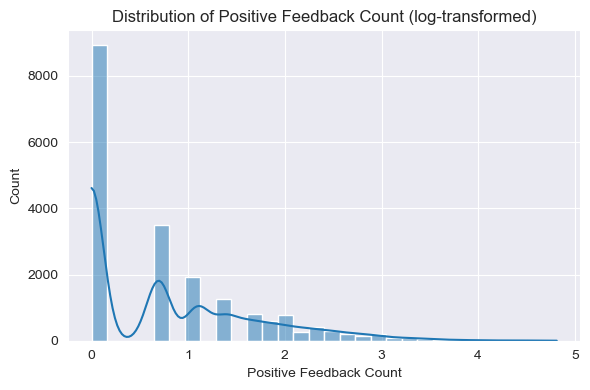

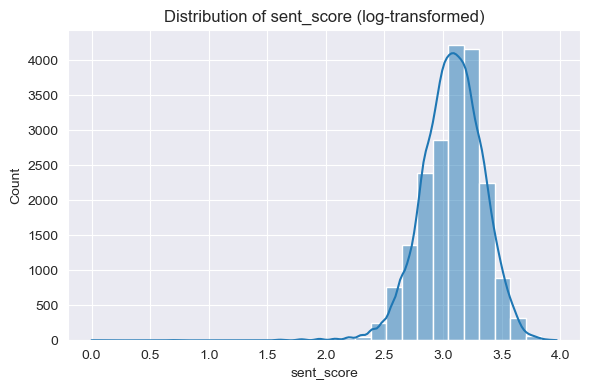

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

for i, col in enumerate(scores_updated.columns):
    plt.figure(i, figsize=(6, 4))
    sns.histplot(scores_updated[col], kde=True, bins=30)
    plt.title(f'Distribution of {col} (log-transformed)')
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()

plt.show()


## Après la transformation logarithmique, l'âge et le score de sentiment semblent suivre une distribution normale.
## Nous allons maintenant éliminer les autres variables et appliquer une normalisation par échelle Z, ce qui nous indiquera essentiellement à quelle distance chaque point de données se situe de la moyenne en termes d'écart-type.

In [28]:
from scipy.stats import boxcox
# rendre les données plus noramele 
scores_mod = scores_updated[['Age', 'sent_score']]

from scipy import stats

scores_std = stats.zscore(scores_mod)
scores_std = np.array(scores_std)

In [29]:
scores_std

array([[ 1.28788845, -0.52581089],
       [ 0.64583153,  1.95743013],
       [ 0.42843503, -0.3265031 ],
       ...,
       [-1.02554011,  0.21656288],
       [-1.37854069,  0.98091023],
       [ 0.78376946,  0.21656288]])

Chercher le meilleur kn avec la méthode du coude(Elboww)

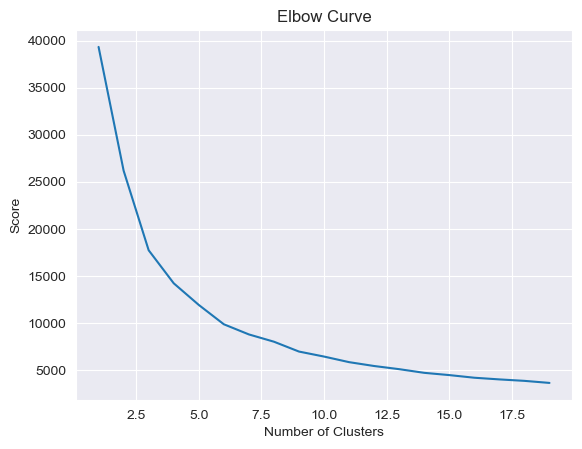

In [30]:
# Utilisation de la méthode du coude (Elbow Method) pour trouver le nombre optimal de clusters.
# Pour cela, nous allons itérer sur différentes valeurs de k,
# et tracer la distance totale intra-cluster pour chaque valeur de K.
import pylab as pl
number_of_clusters = range(1,20)
kmeans = [KMeans(n_clusters=i,max_iter=1000,random_state=42) for i in number_of_clusters]
score = [-1*kmeans[i].fit(scores_std).score(scores_std) for i in range(len(kmeans))]
pl.plot((number_of_clusters),score)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show();

In [37]:
#kmeans_test = KMeans(n_clusters = 6, max_iter = 10000, random_state = 42)
#-1*kmeans_test.fit(scores_std).score(scores_std)
kmeans_test = KMeans(n_clusters=6, max_iter=10000, random_state=42)
kmeans_test.fit(scores_std)
print(kmeans_test.cluster_centers_)


[[-0.33263955 -1.60745588]
 [ 1.07593452 -0.64366386]
 [-1.52944023 -0.05657799]
 [ 1.05885305  0.88258675]
 [-0.53838826  1.19162374]
 [-0.1745218  -0.07227298]]


In [38]:
scores_data['labels'] = kmeans_test.labels_
scores_data.head()

,Age,Rating,Positive Feedback Count,sent_score,labels
2,60,3,0,5.0,1
3,50,5,0,22.0,3
4,47,5,6,6.0,5
5,49,2,4,7.0,1
6,39,5,1,-3.0,0


In [39]:
cluster_size = scores_data.groupby('labels').size().reset_index()
cluster_size.columns = ['labels', 'number_of_points']
cluster_size['percentage'] = cluster_size['number_of_points']/np.sum(cluster_size['number_of_points'])

cluster_size

,labels,number_of_points,percentage
0,0,2311,0.117536
1,1,3463,0.176127
2,2,2660,0.135286
3,3,3366,0.171193
4,4,2918,0.148408
5,5,4944,0.251449


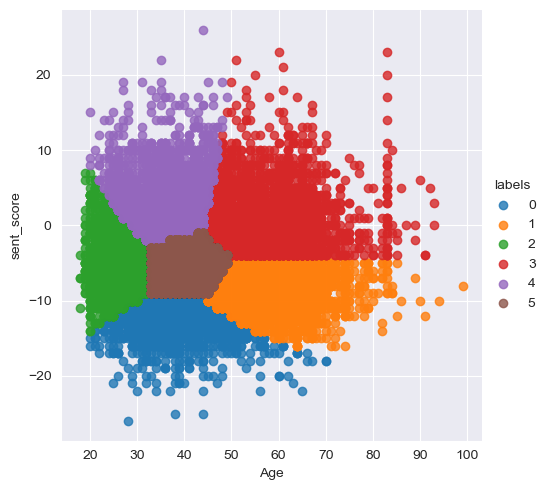

In [40]:
#visualising each of the clusters
scores_data['sent_score'] = scores_data['sent_score'] - min_scores
sns.lmplot(x = 'Age', y = 'sent_score', data = scores_data, hue = 'labels', fit_reg = False)
plt.show();


Cluster 0 → plus jeune avec avis très négatifs

Cluster 1 → plus âgé avec avis négatifs 

Cluster 2 → beaucoup plus jeune avec avis neutres

Cluster 3 → plus âgé avec avis positifs 

Cluster 4 → jeune avec avis très positifs 

Cluster 5 → jeune avec avis neutres

In [49]:
import numpy as np
from afinn import Afinn

af = Afinn()


mean_train = scores_mod.mean().values
std_train = scores_mod.std().values

# Nouvelle donnée brute
new_data = {
    'Age': 60,
    'Review Text': "Didn't like it. Waste of money."
}
"""
tests = [
    {'Age': 33, 'Review Text': "Absolutely wonderful - silky and sexy and comfortable"},
    {'Age': 25, 'Review Text': "Terrible product, broke after 1 day"},
    {'Age': 45, 'Review Text': "Very useful and high quality"},
    {'Age': 60, 'Review Text': "Didn't like it. Waste of money."},
    {'Age': 35, 'Review Text': "Nice fit and lovely color"},
]
"""
# Calcul du score de sentiment
sent_score = af.score(new_data['Review Text'].lower())

# Préparer le vecteur
X_new = np.array([[new_data['Age'], sent_score]])

# Standardisation avec les stats d'entraînement
X_new_std = (X_new - mean_train) / std_train

# Prédiction du cluster
cluster = kmeans_test.predict(X_new_std)

print(f"Le cluster assigné est : {cluster[0]}")


Le cluster assigné est : 1
